# Clasificador de imágenes

In [4]:
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, Input
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.utils import np_utils
import os
import numpy as np
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator 
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


# Configuración de parámetros

In [1]:
width_shape = 224
height_shape = 224
num_classes = 3
epochs = 50
batch_size = 64

# Path de dataset

In [2]:
train_data_dir = 'dataset/train'  
validation_data_dir = 'dataset/valid'

# Generador de imágenes (entrenamiento y validación)

In [5]:
train_datagen = ImageDataGenerator(  
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    preprocessing_function=preprocess_input)

valid_datagen = ImageDataGenerator(    
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(  
    train_data_dir,
    target_size=(width_shape, height_shape),
    batch_size=batch_size,
    #save_to_dir='',
    class_mode='categorical')

validation_generator = valid_datagen.flow_from_directory(  
    validation_data_dir,
    target_size=(width_shape, height_shape),
    batch_size=batch_size,
    #save_to_dir='',
    class_mode='categorical')




Found 2500 images belonging to 3 classes.
Found 1250 images belonging to 3 classes.


# Entrenamiento de modelo VGG16

In [6]:
nb_train_samples = 2500
nb_validation_samples = 1250

image_input = Input(shape=(width_shape, height_shape, 3))

model = VGG16(input_tensor=image_input, include_top=True,weights='imagenet')

last_layer = model.get_layer('fc2').output
out = Dense(num_classes, activation='softmax', name='output')(last_layer)
custom_vgg_model = Model(image_input, out)

for layer in custom_vgg_model.layers[:-1]:
	layer.trainable = False
    

custom_vgg_model.compile(loss='categorical_crossentropy',optimizer='adadelta',metrics=['accuracy'])

custom_vgg_model.summary()

model_history = custom_vgg_model.fit_generator(  
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    steps_per_epoch=nb_train_samples//batch_size,
    validation_steps=nb_validation_samples//batch_size)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

Epoch 35/50
39/39 [==============================] - 352s 9s/step - loss: 0.0117 - accuracy: 0.9959 - val_loss: 0.0032 - val_accuracy: 0.9916
Epoch 36/50
39/39 [==============================] - 352s 9s/step - loss: 0.0094 - accuracy: 0.9979 - val_loss: 0.0094 - val_accuracy: 0.9975
Epoch 37/50
39/39 [==============================] - 353s 9s/step - loss: 0.0100 - accuracy: 0.9975 - val_loss: 0.0158 - val_accuracy: 0.9933
Epoch 38/50
39/39 [==============================] - 352s 9s/step - loss: 0.0069 - accuracy: 0.9979 - val_loss: 0.0021 - val_accuracy: 0.9992
Epoch 39/50
39/39 [==============================] - 352s 9s/step - loss: 0.0317 - accuracy: 0.9881 - val_loss: 0.0015 - val_accuracy: 0.9958
Epoch 40/50
39/39 [==============================] - 353s 9s/step - loss: 0.0119 - accuracy: 0.9947 - val_loss: 0.0032 - val_accuracy: 0.9958
Epoch 41/50
39/39 [==============================] - 354s 9s/step - loss: 0.0038 - accuracy: 0.9996 - val_loss: 0.0070 - val_accuracy: 0.9967
Epoch 

# Grabar modelo en disco

In [7]:
custom_vgg_model.save("models/model_VGG16_Shiane.h5")

# Gráficas de entrenamiento y validación (accuracy - loss)

In [8]:
def plotTraining(hist, epochs, typeData):
    
    if typeData=="loss":
        plt.figure(1,figsize=(10,5))
        yc=hist.history['loss']
        xc=range(epochs)
        plt.ylabel('Loss', fontsize=24)
        plt.plot(xc,yc,'-r',label='Loss Training')
    if typeData=="accuracy":
        plt.figure(2,figsize=(10,5))
        yc=hist.history['accuracy']
        for i in range(0, len(yc)):
            yc[i]=100*yc[i]
        xc=range(epochs)
        plt.ylabel('Accuracy (%)', fontsize=24)
        plt.plot(xc,yc,'-r',label='Accuracy Training')
    if typeData=="val_loss":
        plt.figure(1,figsize=(10,5))
        yc=hist.history['val_loss']
        xc=range(epochs)
        plt.ylabel('Loss', fontsize=24)
        plt.plot(xc,yc,'--b',label='Loss Validate')
    if typeData=="val_accuracy":
        plt.figure(2,figsize=(10,5))
        yc=hist.history['val_accuracy']
        for i in range(0, len(yc)):
            yc[i]=100*yc[i]
        xc=range(epochs)
        plt.ylabel('Accuracy (%)', fontsize=24)
        plt.plot(xc,yc,'--b',label='Training Validate')
        

    plt.rc('xtick',labelsize=24)
    plt.rc('ytick',labelsize=24)
    plt.rc('legend', fontsize=18) 
    plt.legend()
    plt.xlabel('Number of Epochs',fontsize=24)
    plt.grid(True)

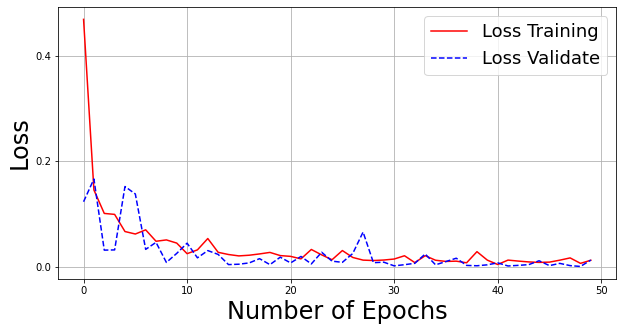

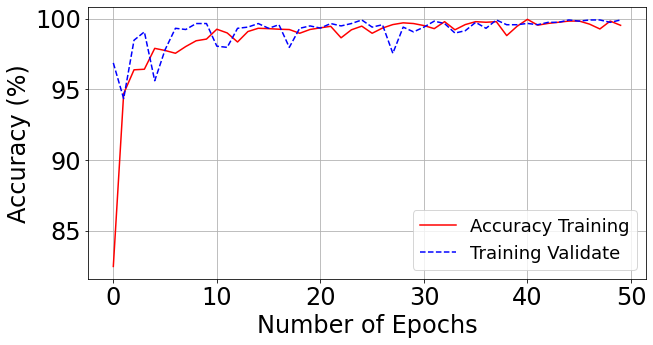

In [9]:
plotTraining(model_history,epochs,"loss")
plotTraining(model_history,epochs,"accuracy")
plotTraining(model_history,epochs,"val_loss")
plotTraining(model_history,epochs,"val_accuracy")

Dmanganeso


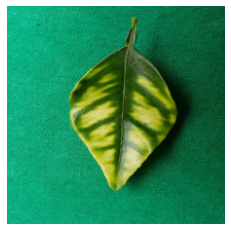

In [10]:
import cv2
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.models import load_model

names = ['Dmanganeso','Dzinc','Sanas']

modelt = load_model("models/model_VGG16_Shiane.h5")
#modelt = custom_vgg_model

imaget_path = "1.jpg"
imaget=cv2.resize(cv2.imread(imaget_path), (width_shape, height_shape), interpolation = cv2.INTER_AREA)
xt = np.asarray(imaget)
xt=preprocess_input(xt)
xt = np.expand_dims(xt,axis=0)
preds = modelt.predict(xt)

print(names[np.argmax(preds)])
plt.imshow(cv2.cvtColor(np.asarray(imaget),cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [11]:
!pip install mlxtend

In [11]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, precision_score, recall_score, accuracy_score, roc_auc_score
from mlxtend.plotting import plot_confusion_matrix


Found 1250 images belonging to 3 classes.
              precision    recall  f1-score   support

           0     0.8617    0.8720    0.8668       250
           1     1.0000    0.6060    0.7547       500
           2     0.7104    0.9860    0.8258       500

    accuracy                         0.8112      1250
   macro avg     0.8573    0.8213    0.8158      1250
weighted avg     0.8565    0.8112    0.8055      1250



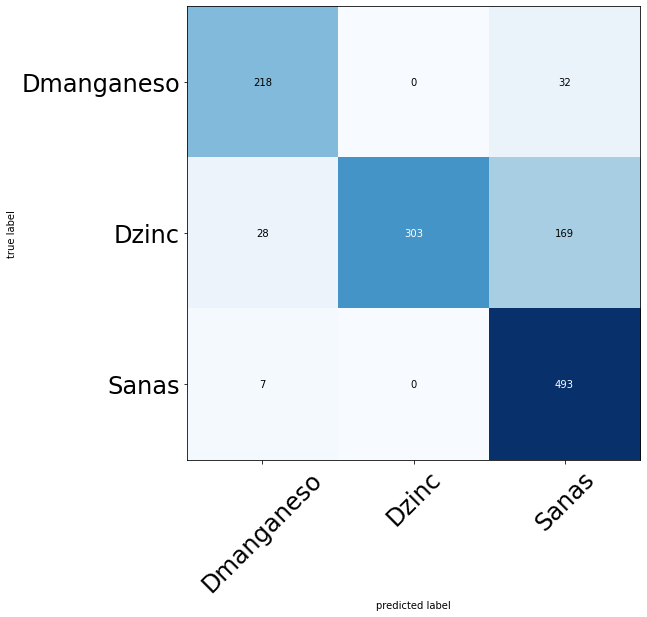

In [12]:
width_shape=224
height_shape=224
batch_size=64
names=['Dmanganeso','Dzinc','Sanas']
test_data_dir = 'dataset/test'  

test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(width_shape, height_shape), 
    batch_size = batch_size,
    class_mode='categorical', 
    shuffle=False)


custom_Model= load_model("models/model_VGG16_Shiane.h5")

predictions = custom_Model.predict_generator(generator=test_generator)

y_pred = np.argmax(predictions, axis=1)
y_real = test_generator.classes
matc=confusion_matrix(y_real, y_pred)

plot_confusion_matrix(conf_mat=matc, figsize=(9,9), class_names = names, show_normed=False)
plt.tight_layout()
print(metrics.classification_report(y_real,y_pred, digits = 4))